### Result Report - Comparing TxGNN to Every Cure baseline based on simplified KG2.7.3

**Author**: Chunyu Ma

**Date**: 03-04-2025

**Background and Motivation**: [The TxGNN paper](https://www.nature.com/articles/s41591-024-03233-x) demonstrates strong performance on PrimeKG for drug repurposing. We aim to explore its capability of drug repurposing using KG2.7.3 so that we can compare its performance to the Every Cuire baseline model (derived from [KGML-xDTD](https://academic.oup.com/gigascience/article/doi/10.1093/gigascience/giad057/7246583)). 

**Method**: In this experiment, we basically used two data split methods (randam split and disease split) in this experiement. For random split, we used the train, validation, test sets generated by the KGML-xDTD paper which used a split ratio of 8/1/1. For disease split, we followed the method of zero-shot drug-repurposing evaluation across disease areas from the TxGNN paper, which tried to hold out a group of biologically related diseases from training dataset and remove all indication and contraindications assocaited with these diseases along with randomly 10% of edges in each non indication/contraindication relationships between these related diseases and other meidcal concepts in the KG. Although the version of KG2.7.3 has been a prefiltered version from the KGML-xDTD paper, which has filtered part of node types and edges (see more details in the paper if you are interested), its size is still much larger than PrimeKG, resulting in an "out of memory" issue when running the TxGNN model. To successfully run the TxGNN model, we need to simplify KG2.7.3 to reduce the graph size, which involves the exclusion of some node types (e.g., "CellLine", "Food") that are not meaningful for drug repurposing prediction or explanation, as well as merging some node types based on biolink hierarchy structure. 

The ground truth data used in this experiment is mainly from the KGML-xDTD paper, which has 21,437 indications and 33,189 contraindications. 

The evaluation metrics include full-matrix ranking metrics (Recall@n, AUPROC), disease-specific ranking metrics (Hit@k, MRR), and ground-truth classification metrics (Accuracy, F1 score). More detailed explanation about these metrics can be seen in [this](https://docs.dev.everycure.org/data_science/evaluation_deep_dive/) webpage. 

**Results**: The performance of TxGNN based on the simplified KG2.7.3 does not appear to be better than that of the Every Cuire baseline model (KGML-xDTD), but even worse in most evaluation metrics, particularly in the full matrix ranking metrics. However, when evaluated using the disease split method for certain diseases, TxGNN shows slightly improved results.

In [1]:
from IPython.utils import io

with io.capture_output() as captured:
    %load_ext kedro.ipython
    %reload_kedro

import os
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import pickle

#### Model Parameters

##### TxGNN

Please find code (https://github.com/everycure-org/lab-notebooks/tree/chunyu-dev-KG2_TxGNN_zero-shot_pipeline/TxGNN_exploration/txgnn-experimental-kedro-pipeline)

- input embedding size (n_inp): 256
- hidden embedding size (n_hid): 256
- output embedding size (n_out): 256
- whether to use metric learning module (proto): true
- number of similar diseases to retrieve for augmentation (proto_num): 3
- use attention layer (attention): false
- disease signature method (sim_measure): all_nodes_profile
- how to aggregate sim disease emb with target disease emb (agg_measure): 'rarity'
- length of path (path_length): 2
- number of epoch for pretrain step: 1
- number of learning rate for pretrain step: 1.0e-3
- batch size for pretrain step: 512
- number of epoch for finetune step: 1000
- number of learning rate for finetune step: 5.0e-4


##### KGML-xDTD

Please find code (https://github.com/everycure-org/lab-notebooks/tree/chunyu-dev-KG2_TxGNN_zero-shot_pipeline/TxGNN_exploration/retrain_kgml_xdtd_kg2)

GraphSAGE

- walk length: 100
- number of walks: 10
- batch size for random walk: 200000
- model size: "big"
- learning rate: 0.001
- number of epoch: 1
- maximum node degree: 96
- number of samples in layer 1: 96
- number of samples in layer 2: 96
- Size of output dim in layer 1 (final is 2x this, if using concat)': 128
- Size of output dim in layer 2 (final is 2x this, if using concat)': 128
- model: 'graphsage_mean'
- batch size: 512

Random Forest

Note that the paramters of ML model are optimized by the scikit-learn's GridSearchCV function. 

- class_weight: 'balanced_subsample'
- max_depth: 35
- n_estimators: 1000
- random_state:1023


#### Random split Method

The random split method used the data sets generated by the KGML-xDTD paper, where the training set has 17,149 indications and 26,552 contraindications, the validation set has 2,143 indications and 3,318 contraindications, and the test set has 2,145 indications and 3,319 contraindications. In order to evaluate the models' performance in more data, the Every Cure's ground truth data (Release v.0.1.2 downloaded from https://github.com/everycure-org/matrix-indication-list/releases/tag/v0.1.2) were also used. This release version contains 15,744 indication pairs and 102,968 contraindication pairs. After processing step (e.g., normalizing pairs to nodes in the simplified KG, and filtering out the pairs that have been used as train and valid set from the KGML-xDTD ground truth), finally 8,670 indication pairs and 61,793 contraindication pairs from this release version are used as an additional ground truths for evaluation.

In [5]:
# set result path
result_path = '/home/grads/cqm5886/work/lab-notebooks/TxGNN_exploration/txgnn-experimental-kedro-pipeline/data/08_reporting/original_split'

# set up variable names
result_file_names = ['disease_specific_ranking_result', 'ground_truth_classification_result', 'full_matrix_ranking_result']
kgml_model = 'kgml_xdtd'
txgnn_model = 'treatment_pred'

##### Performance Comparison Using KGML-xDTD’s Ground Truths

In [6]:
result_dict = {}
for model in [kgml_model, txgnn_model]:
    result_dict[model] = {}
    for result_file_name in result_file_names:
        file_path = f'{result_path}/{model}_{result_file_name}_backup.pkl'
        
        with open(file_path, 'rb') as f:
            result = pickle.load(f)
        if result_file_name == 'disease_specific_ranking_result':
            result_dict[model]['MRR'] = result['mrr']
            result_dict[model].update({x.capitalize(): result[x] for x in ['hit@1', 'hit@5', 'hit@10', 'hit@50', 'hit@100', 'hit@500', 'hit@1000'] })
        elif result_file_name == 'ground_truth_classification_result':
            result_dict[model]['Accuracy'] = result['acc']
            result_dict[model]['F1'] = result['f1']
        else:
            result_dict[model]['AUROC'] = result['AUROC']
            result_dict[model].update({x.capitalize(): result[x] for x in ['recall@10', 'recall@100', 'recall@1000', 'recall@10000', 'recall@100000', 'recall@1000000'] })

# Organize data to a dataframe
model_name_map = {
    'KGML-xDTD': 'kgml_xdtd',
    'TxGNN': 'treatment_pred',
}

data = {
    "Model": ["KGML-xDTD", "TxGNN"]
}

for model in data["Model"]:
    for metric in ["Accuracy", "F1", "MRR", "AUROC","Hit@1", "Hit@10", "Hit@100", "Recall@100", "Recall@1000", "Recall@10000", "Recall@100000"]:
        if metric not in data:
            data[metric] = []
        data[metric].append(result_dict[model_name_map[model]][metric])

# Create DataFrame
df = pd.DataFrame(data)

# Print a formatted table
print(tabulate(df, headers="keys", tablefmt="github", showindex=False))



| Model     |   Accuracy |       F1 |      MRR |    AUROC |     Hit@1 |   Hit@10 |   Hit@100 |   Recall@100 |   Recall@1000 |   Recall@10000 |   Recall@100000 |
|-----------|------------|----------|----------|----------|-----------|----------|-----------|--------------|---------------|----------------|-----------------|
| KGML-xDTD |   0.931369 | 0.910693 | 0.133088 | 0.93547  | 0.0856955 | 0.226763 |  0.520765 |   0.0123119  |     0.0369357 |      0.125855  |        0.359781 |
| TxGNN     |   0.836567 | 0.776134 | 0.104908 | 0.911288 | 0.0494397 | 0.19644  |  0.621622 |   0.00136799 |     0.0150479 |      0.0738714 |        0.201094 |


As we can see, the KGML-xDTD's perforamnce is better than TxGNN in most metrics except for "Hit@100" when using KGML-xDTD's ground truths. 

##### Performance Comparison Using Every Cure’s Ground Truths

In [7]:
result_dict = {}
for model in [kgml_model, txgnn_model]:
    result_dict[model] = {}
    for result_file_name in result_file_names:
        file_path = f'{result_path}/{model}_{result_file_name}.pkl'
        
        with open(file_path, 'rb') as f:
            result = pickle.load(f)
        if result_file_name == 'disease_specific_ranking_result':
            result_dict[model]['MRR'] = result['mrr']
            result_dict[model].update({x.capitalize(): result[x] for x in ['hit@1', 'hit@5', 'hit@10', 'hit@50', 'hit@100', 'hit@500', 'hit@1000'] })
        elif result_file_name == 'ground_truth_classification_result':
            result_dict[model]['Accuracy'] = result['acc']
            result_dict[model]['F1'] = result['f1']
            temp_df = pd.DataFrame(zip(result['y_true'], result['y_pred']), columns=['y_true', 'y_pred'])
            result_dict[model]['Recall'] = len(temp_df[(temp_df.y_true == 1) & temp_df.y_pred == 1])/len(temp_df[temp_df.y_true == 1])
        else:
            result_dict[model]['AUROC'] = result['AUROC']
            result_dict[model].update({x.capitalize(): result[x] for x in ['recall@10', 'recall@100', 'recall@1000', 'recall@10000', 'recall@100000', 'recall@1000000'] })

# Organize data to a dataframe
model_name_map = {
    'KGML-xDTD': 'kgml_xdtd',
    'TxGNN': 'treatment_pred',
}

data = {
    "Model": ["KGML-xDTD", "TxGNN"]
}

for model in data["Model"]:
    for metric in ["Recall", "Accuracy", "F1", "MRR", "AUROC", "Hit@1", "Hit@10", "Hit@100", "Recall@100", "Recall@1000", "Recall@10000", "Recall@100000"]:
        if metric not in data:
            data[metric] = []
        data[metric].append(result_dict[model_name_map[model]][metric])

# Create DataFrame
df = pd.DataFrame(data)

# Print a formatted table
print(tabulate(df, headers="keys", tablefmt="github", showindex=False))


| Model     |   Recall |   Accuracy |       F1 |       MRR |    AUROC |     Hit@1 |    Hit@10 |   Hit@100 |   Recall@100 |   Recall@1000 |   Recall@10000 |   Recall@100000 |
|-----------|----------|------------|----------|-----------|----------|-----------|-----------|-----------|--------------|---------------|----------------|-----------------|
| KGML-xDTD | 0.847636 |   0.418432 | 0.263987 | 0.0481672 | 0.817365 | 0.022186  | 0.0935071 |  0.270494 |  0.000745712 |    0.00646284 |      0.0270942 |       0.120805  |
| TxGNN     | 0.565283 |   0.699104 | 0.316153 | 0.0355847 | 0.752097 | 0.0140386 | 0.0666834 |  0.299198 |  0           |    0.00174    |      0.01392   |       0.0681084 |


When using Every Cure's ground truths, which has more much indication pairs and contraindication pairs than KGML-xDTD's ground truths, we noticed a significant decline in the performance of both models. However, by observing Recall and Accuracy, we found that  KGML-xDTD excels at identifying indication relationships, outperforming TxGNN. However, for contraindications, TxGNN performs better, although it is still not as effective overall. Since there are many reasons that cause a drug fail in the treatment experiments, this may explain why both models cannot work well for the identification of contraindication relationship.

#### Disease split Method

For disease split experiment, we mainly used KGML-xDTD's ground truths (GTs). By utilizing ChatGPT 4o-mini, we categorized all diseases in GTs into 11 categories:

- Diabetes related diseases (1,025 indications, 1,944 contraindications)
- Hormonal diseases (586 indications, 1,599 contraindications)
- Auto-immune diseases (1,481 indications, 1,635 contraindications)
- Anaemia (133 indications, 847 contraindications)
- Neurodegenerative diseases (809 indications, 1,159 contraindications)
- Mental health disorders (1,996 indications, 1,839 contraindications)
- Metabolic disorders (407 indications, 1,470 contraindications)
- Cardiovascular disorders (1,490 indications, 4,959 contraindications)
- Cancerous diseases (3,559 indications, 1,655 contraindications)
- Infectious diseases/pathogen caused diseases (3,928 indications, 656 contraindications)
- Others (6,023 indications, 15,426 contraindications)

According to the TxGNN's performance in the zero-shot evaluation reported in the paper, we separately chose three diseases (e.g.,Auto-immune diseases, Neurodegenerative diseases, Infectious diseases/pathogen caused diseases) as a holdout dataset to compare TxGNN's performance with KGML-xDTD based on the simplified KG2.7.3.

To eliminate the influence of the PubmedBert model, we included a variant of TxGNN (i.e., TxGNN-PubmedBert) in the comparison, where we let TxGNN used the same PubmedBert embeddings as what KGML-xDTD used to perform the metric learning calculation (the correlation matrix of diseases).

In [2]:
# Set global font sizes with much larger values
plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 28,
    'axes.labelsize': 26,
    'xtick.labelsize': 24,
    'ytick.labelsize': 20,
    'legend.fontsize': 20
})

# Define new model names for legend
model1_legend = 'TxGNN'
model2_legend = 'TxGNN-PubmedBERT'
model3_legend = 'KGML-XDTD'

#### Infectious Or Pathogen Caused Disease

In [3]:
disease_folder_name = 'infectious_or_pathogen_caused_disease_split'
orig_path = f'/home/grads/cqm5886/work/lab-notebooks/TxGNN_exploration/txgnn-experimental-kedro-pipeline/data/08_reporting/{disease_folder_name}'

result_file_names = ['disease_specific_ranking_result', 'ground_truth_classification_result', 'full_matrix_ranking_result']
model1 = 'treatment_pred'
model2 = 'treatment_pred_pubmedbert'
model3 = 'kgml_xdtd'

result_dict = {}
for model in [model1, model2, model3]:
    result_dict[model] = {}
    if model == 'treatment_pred_pubmedbert':
        path = f"{orig_path}_pubmed_bert"
    else:
        path = f"{orig_path}"
    for result_file_name in result_file_names:
        if model == 'treatment_pred_pubmedbert':
            # replace "treatment_pred" with "treatment_pred_pubmedbert"
            result_file_name = result_file_name.replace("treatment_pred", "treatment_pred_pubmedbert")
            file_path = f'{path}/{model}_{result_file_name}.pkl'
        else:
            file_path = f'{path}/{model}_{result_file_name}.pkl'
        
        with open(file_path, 'rb') as f:
            result = pickle.load(f)
        if result_file_name == 'disease_specific_ranking_result':
            result_dict[model]['mrr'] = result['mrr']
            result_dict[model].update({x: result[x] for x in ['hit@1', 'hit@5', 'hit@10', 'hit@50', 'hit@100', 'hit@500', 'hit@1000'] })
        elif result_file_name == 'ground_truth_classification_result':
            result_dict[model]['acc'] = result['acc']
            result_dict[model]['f1'] = result['f1']
        else:
            result_dict[model]['AUROC'] = result['AUROC']
            result_dict[model].update({x: result[x] for x in ['recall@10', 'recall@100', 'recall@1000', 'recall@10000', 'recall@100000', 'recall@1000000'] })

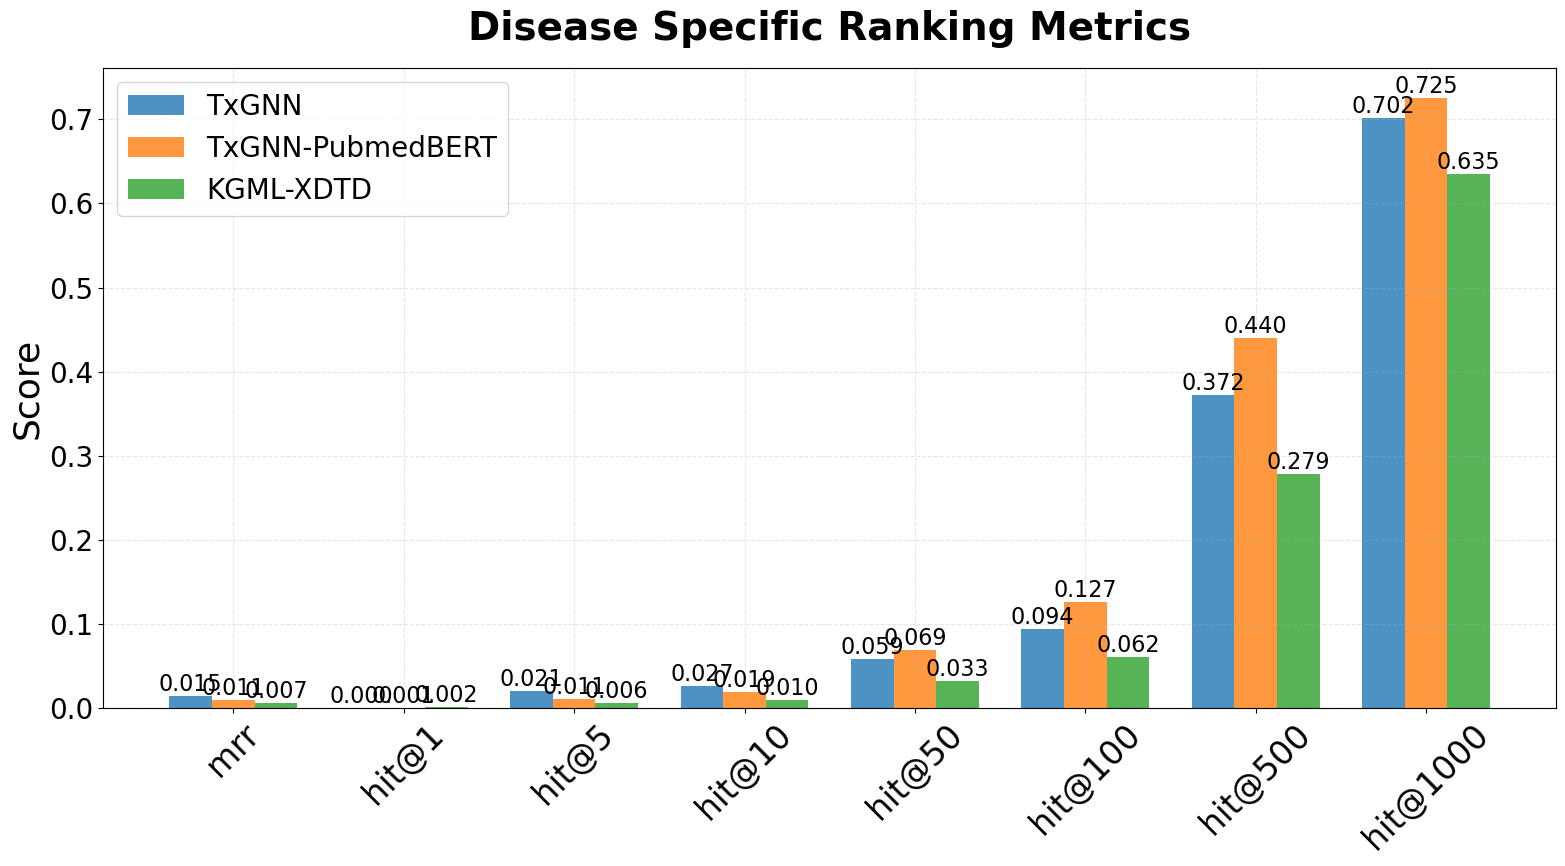

In [ ]:
# 1. Disease Specific Ranking Plot
disease_metrics = ['mrr', 'hit@1', 'hit@5', 'hit@10', 'hit@50', 'hit@100', 'hit@500', 'hit@1000']
x = np.arange(len(disease_metrics))
width = 0.25  # Changed from 0.35 to accommodate three bars

fig, ax = plt.subplots(figsize=(16, 9))
bars1 = ax.bar(x - width, [result_dict[model1][m] for m in disease_metrics], width, 
       label=model1_legend, alpha=0.8)
bars2 = ax.bar(x, [result_dict[model2][m] for m in disease_metrics], width, 
       label=model2_legend, alpha=0.8)
bars3 = ax.bar(x + width, [result_dict[model3][m] for m in disease_metrics], width, 
       label=model3_legend, alpha=0.8)

def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height,
                f'{height:.3f}',
                ha='center', va='bottom', rotation=0, fontsize=16)

autolabel(bars1)
autolabel(bars2)
autolabel(bars3)
ax.set_ylabel('Score')
ax.set_title('Disease Specific Ranking Metrics', pad=20, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(disease_metrics, rotation=45)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend()  # Uncommented the legend
plt.subplots_adjust(right=0.95)  # Adjusted right margin
plt.tight_layout()
plt.show()

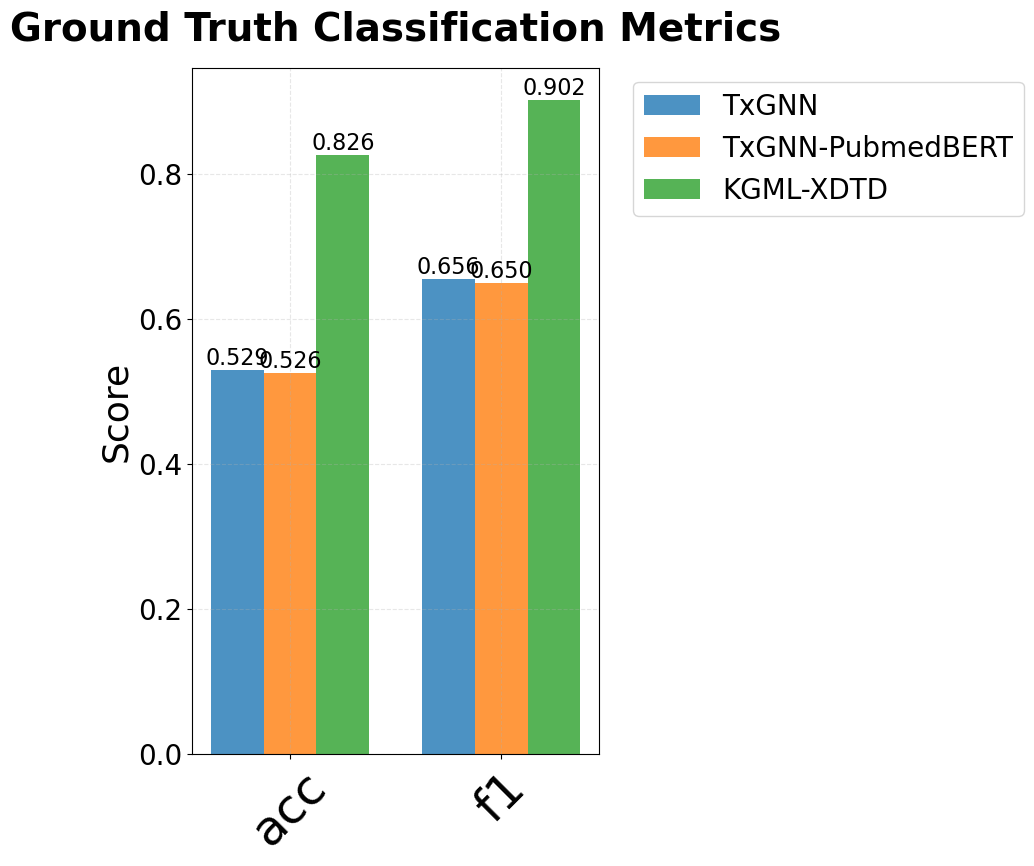

In [6]:
# 2. Ground Truth Classification Plot
metrics = ['acc', 'f1']  # Added f1 metric
x = np.arange(len(metrics))

fig, ax = plt.subplots(figsize=(10, 9))
bars1 = ax.bar(x - width, [result_dict[model1][m] for m in metrics], width, 
       label=model1_legend, alpha=0.8)
bars2 = ax.bar(x, [result_dict[model2][m] for m in metrics], width, 
       label=model2_legend, alpha=0.8)
bars3 = ax.bar(x + width, [result_dict[model3][m] for m in metrics], width, 
       label=model3_legend, alpha=0.8)

autolabel(bars1)
autolabel(bars2)
autolabel(bars3)

ax.set_ylabel('Score')
ax.set_title('Ground Truth Classification Metrics', pad=20, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, fontsize=35)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
plt.subplots_adjust(right=0.95)  # Adjusted right margin
plt.tight_layout()
plt.show()

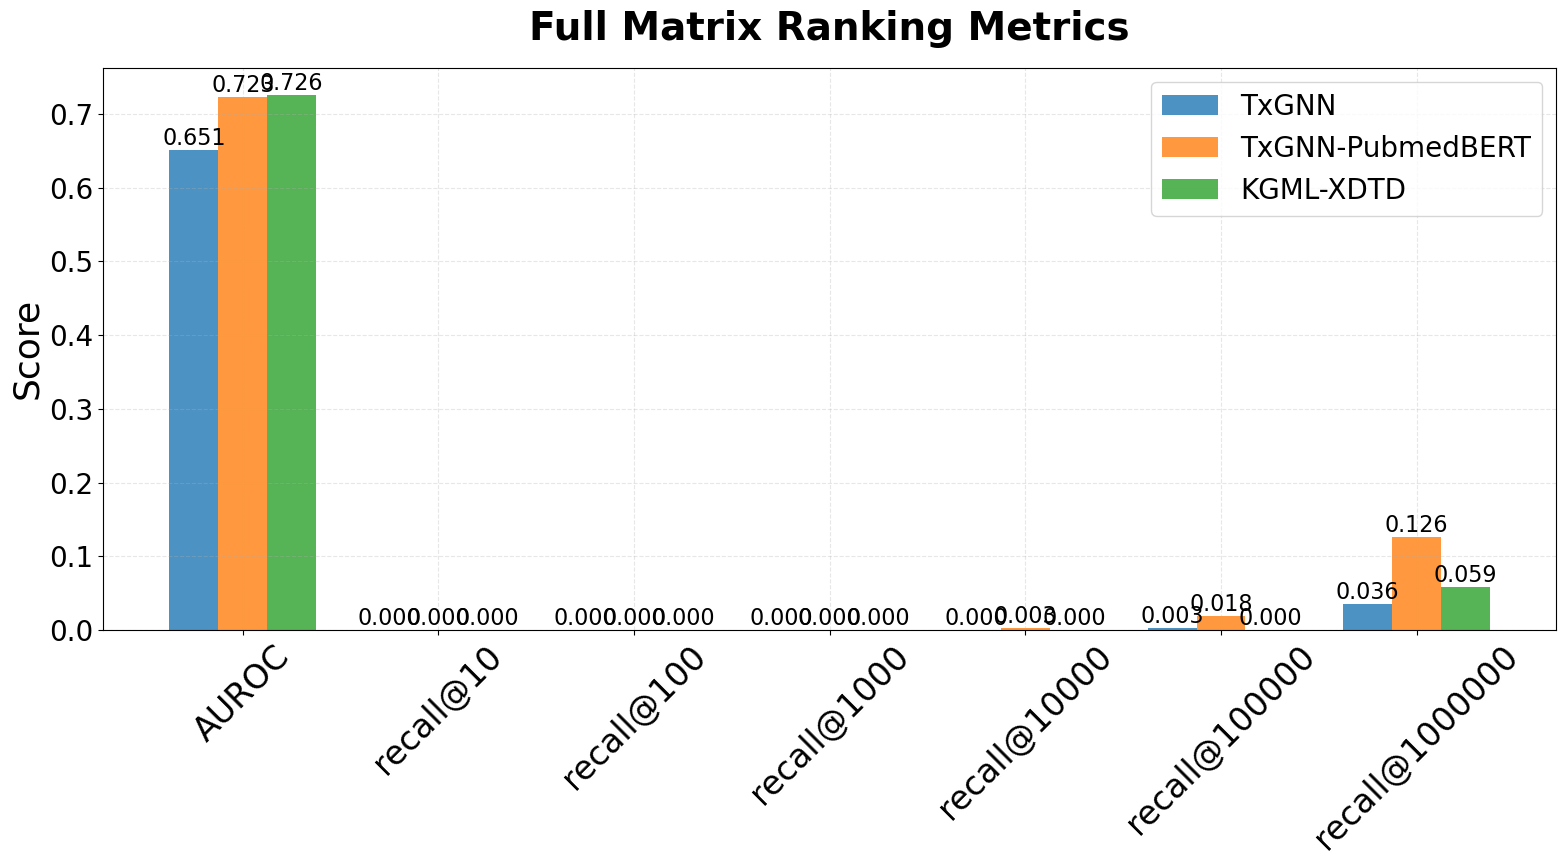

In [7]:
# 3. Full Matrix Ranking Plot
matrix_metrics = ['AUROC', 'recall@10', 'recall@100', 'recall@1000', 
                 'recall@10000', 'recall@100000', 'recall@1000000']
x = np.arange(len(matrix_metrics))

fig, ax = plt.subplots(figsize=(16, 9))
bars1 = ax.bar(x - width, [result_dict[model1][m] for m in matrix_metrics], width, 
       label=model1_legend, alpha=0.8)
bars2 = ax.bar(x, [result_dict[model2][m] for m in matrix_metrics], width, 
       label=model2_legend, alpha=0.8)
bars3 = ax.bar(x + width, [result_dict[model3][m] for m in matrix_metrics], width, 
       label=model3_legend, alpha=0.8)

autolabel(bars1)
autolabel(bars2)
autolabel(bars3)

ax.set_ylabel('Score')
ax.set_title('Full Matrix Ranking Metrics', pad=20, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(matrix_metrics, rotation=45)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend()  # Added legend back
plt.subplots_adjust(right=0.95)  # Adjusted right margin
plt.tight_layout()
plt.show()

From the zero-shot evalution for "Infectious Or Pathogen Caused Disease, we can see TxGNN has better performance in the disease specific ranking metrics but is worse in ground truth classification metrics and full matrix ranking metrics compared with KGML-xDTD. However, we noticed that the PubmedBert embeddings can further improve TxGNN's performance in the ranking metrics.

#### Auto-immune Disease

In [8]:
disease_folder_name = 'auto_immune_disease_split'
orig_path = f'/home/grads/cqm5886/work/lab-notebooks/TxGNN_exploration/txgnn-experimental-kedro-pipeline/data/08_reporting/{disease_folder_name}'

result_file_names = ['disease_specific_ranking_result', 'ground_truth_classification_result', 'full_matrix_ranking_result']
model1 = 'treatment_pred'
model2 = 'treatment_pred_pubmedbert'
model3 = 'kgml_xdtd'

result_dict = {}
for model in [model1, model2, model3]:
    result_dict[model] = {}
    if model == 'treatment_pred_pubmedbert':
        path = f"{orig_path}_pubmed_bert"
    else:
        path = f"{orig_path}"
    for result_file_name in result_file_names:
        if model == 'treatment_pred_pubmedbert':
            # replace "treatment_pred" with "treatment_pred_pubmedbert"
            result_file_name = result_file_name.replace("treatment_pred", "treatment_pred_pubmedbert")
            file_path = f'{path}/{model}_{result_file_name}.pkl'
        else:
            file_path = f'{path}/{model}_{result_file_name}.pkl'
        
        with open(file_path, 'rb') as f:
            result = pickle.load(f)
        if result_file_name == 'disease_specific_ranking_result':
            result_dict[model]['mrr'] = result['mrr']
            result_dict[model].update({x: result[x] for x in ['hit@1', 'hit@5', 'hit@10', 'hit@50', 'hit@100', 'hit@500', 'hit@1000'] })
        elif result_file_name == 'ground_truth_classification_result':
            result_dict[model]['acc'] = result['acc']
            result_dict[model]['f1'] = result['f1']
        else:
            result_dict[model]['AUROC'] = result['AUROC']
            result_dict[model].update({x: result[x] for x in ['recall@10', 'recall@100', 'recall@1000', 'recall@10000', 'recall@100000', 'recall@1000000'] })

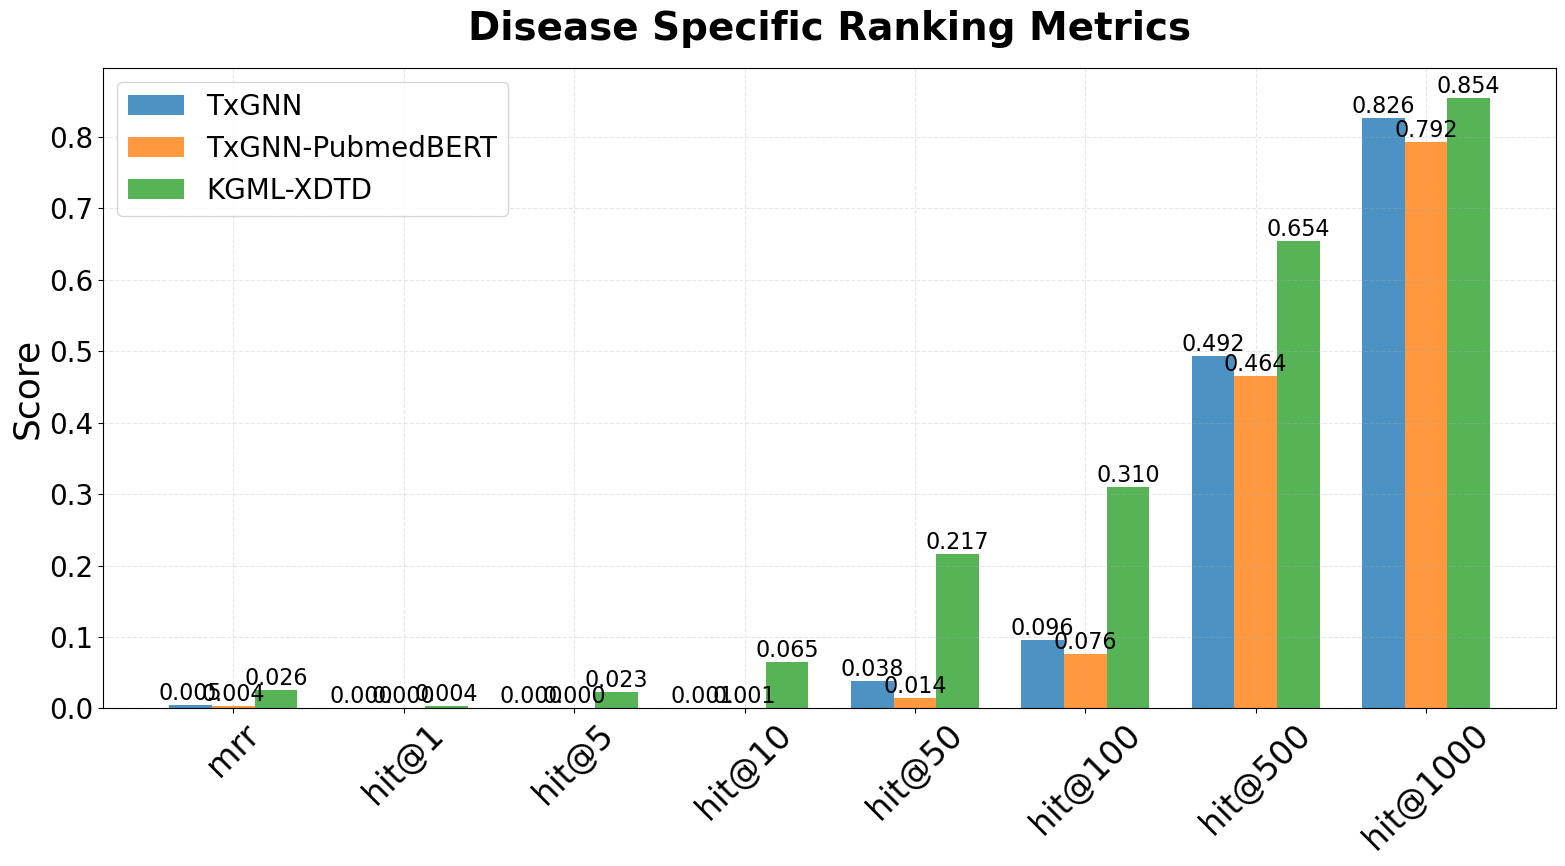

In [9]:
# 1. Disease Specific Ranking Plot
disease_metrics = ['mrr', 'hit@1', 'hit@5', 'hit@10', 'hit@50', 'hit@100', 'hit@500', 'hit@1000']
x = np.arange(len(disease_metrics))
width = 0.25  # Changed from 0.35 to accommodate three bars

fig, ax = plt.subplots(figsize=(16, 9))
bars1 = ax.bar(x - width, [result_dict[model1][m] for m in disease_metrics], width, 
       label=model1_legend, alpha=0.8)
bars2 = ax.bar(x, [result_dict[model2][m] for m in disease_metrics], width, 
       label=model2_legend, alpha=0.8)
bars3 = ax.bar(x + width, [result_dict[model3][m] for m in disease_metrics], width, 
       label=model3_legend, alpha=0.8)

def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height,
                f'{height:.3f}',
                ha='center', va='bottom', rotation=0, fontsize=16)

autolabel(bars1)
autolabel(bars2)
autolabel(bars3)
ax.set_ylabel('Score')
ax.set_title('Disease Specific Ranking Metrics', pad=20, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(disease_metrics, rotation=45)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
ax.legend()  # Uncommented the legend
plt.subplots_adjust(right=0.95)  # Adjusted right margin
plt.tight_layout()
plt.show()

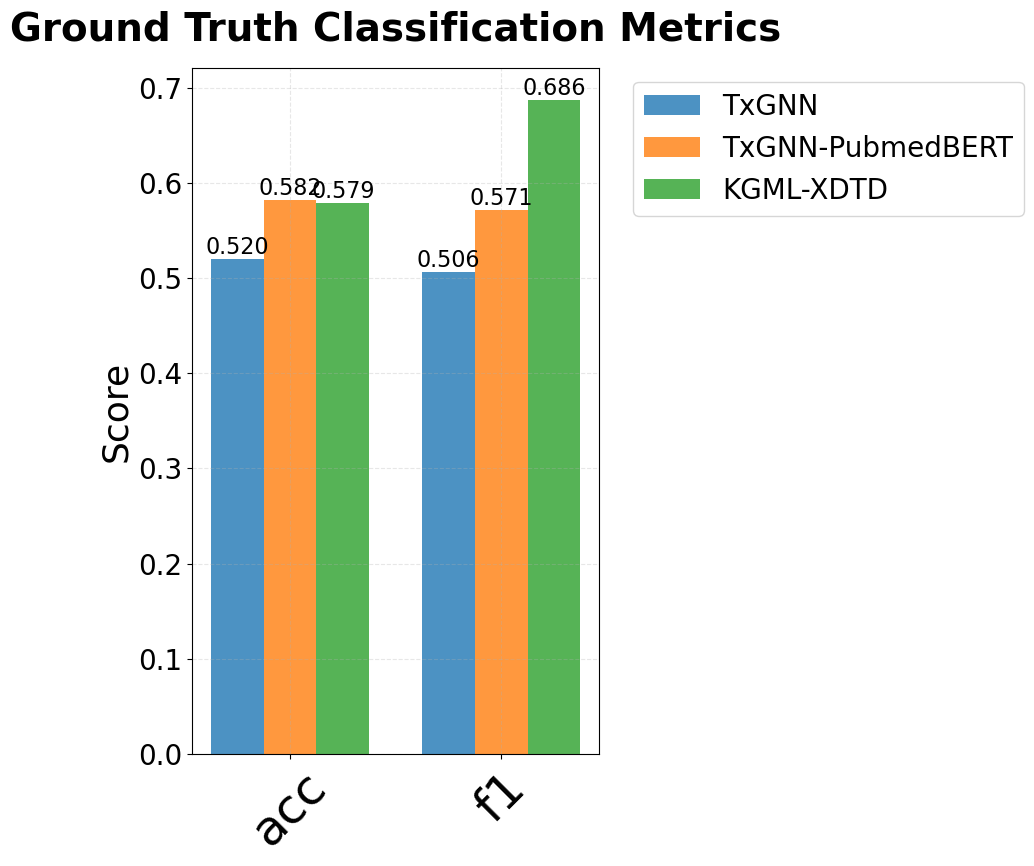

In [10]:
# 2. Ground Truth Classification Plot
metrics = ['acc', 'f1']  # Added f1 metric
x = np.arange(len(metrics))

fig, ax = plt.subplots(figsize=(10, 9))
bars1 = ax.bar(x - width, [result_dict[model1][m] for m in metrics], width, 
       label=model1_legend, alpha=0.8)
bars2 = ax.bar(x, [result_dict[model2][m] for m in metrics], width, 
       label=model2_legend, alpha=0.8)
bars3 = ax.bar(x + width, [result_dict[model3][m] for m in metrics], width, 
       label=model3_legend, alpha=0.8)

autolabel(bars1)
autolabel(bars2)
autolabel(bars3)

ax.set_ylabel('Score')
ax.set_title('Ground Truth Classification Metrics', pad=20, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, fontsize=35)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
plt.subplots_adjust(right=0.95)  # Adjusted right margin
plt.tight_layout()
plt.show()

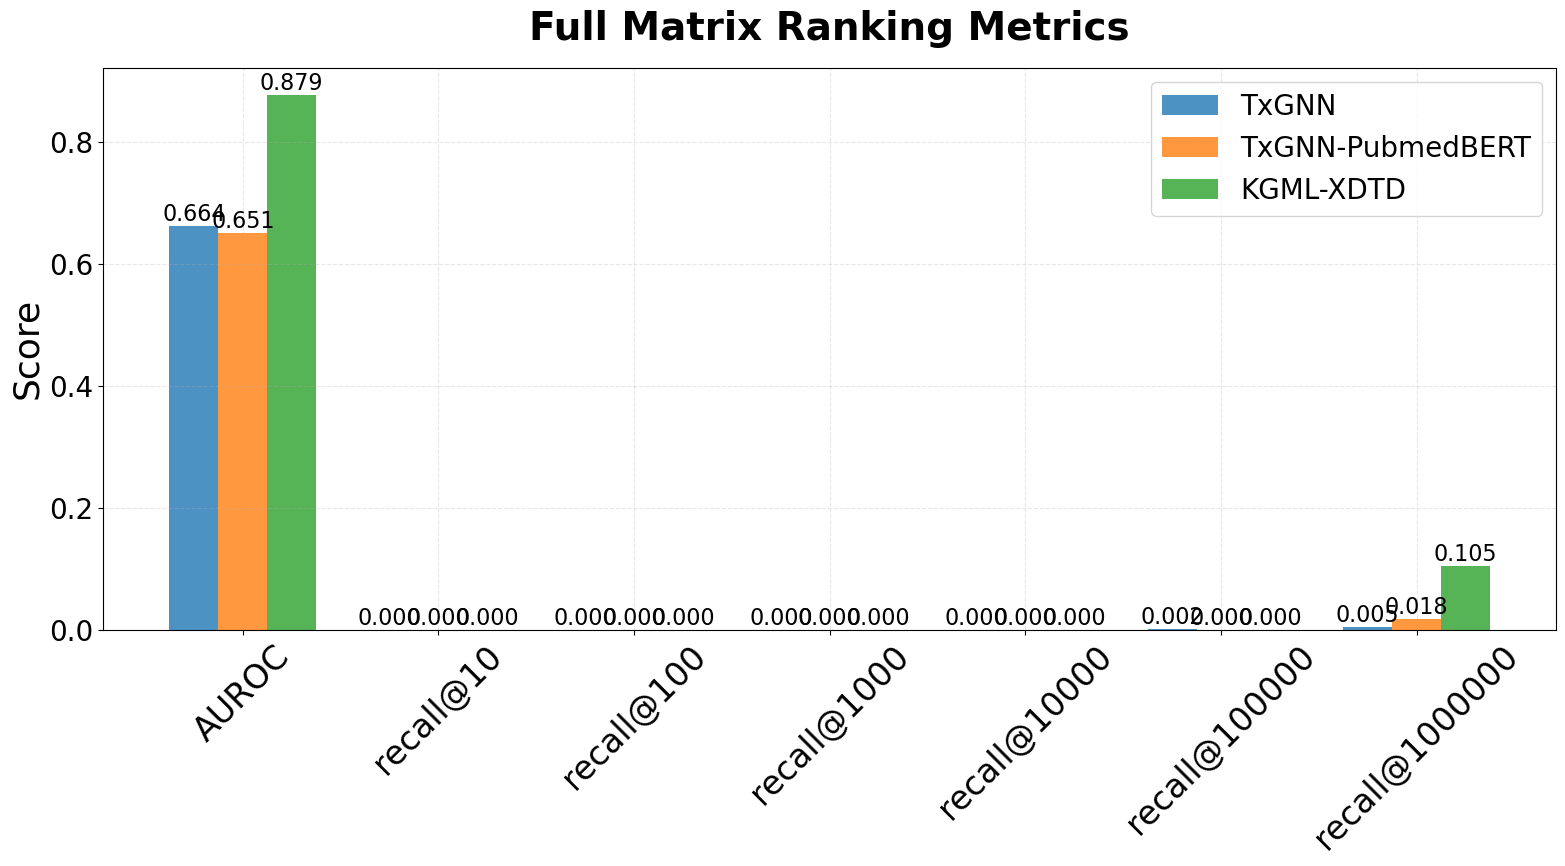

In [11]:
# 3. Full Matrix Ranking Plot
matrix_metrics = ['AUROC', 'recall@10', 'recall@100', 'recall@1000', 
                 'recall@10000', 'recall@100000', 'recall@1000000']
x = np.arange(len(matrix_metrics))

fig, ax = plt.subplots(figsize=(16, 9))
bars1 = ax.bar(x - width, [result_dict[model1][m] for m in matrix_metrics], width, 
       label=model1_legend, alpha=0.8)
bars2 = ax.bar(x, [result_dict[model2][m] for m in matrix_metrics], width, 
       label=model2_legend, alpha=0.8)
bars3 = ax.bar(x + width, [result_dict[model3][m] for m in matrix_metrics], width, 
       label=model3_legend, alpha=0.8)

autolabel(bars1)
autolabel(bars2)
autolabel(bars3)

ax.set_ylabel('Score')
ax.set_title('Full Matrix Ranking Metrics', pad=20, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(matrix_metrics, rotation=45)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend()  # Added legend back
plt.subplots_adjust(right=0.95)  # Adjusted right margin
plt.tight_layout()
plt.show()

The comparison results of "Auto-immune Disease" evalution show that the KGML-xDTD model outperforms TxGNN across all metrics.

#### Neurodegenerative Disease

In [12]:
disease_folder_name = 'neurodegenerative_disease_split'
orig_path = f'/home/grads/cqm5886/work/lab-notebooks/TxGNN_exploration/txgnn-experimental-kedro-pipeline/data/08_reporting/{disease_folder_name}'

result_file_names = ['disease_specific_ranking_result', 'ground_truth_classification_result', 'full_matrix_ranking_result']
model1 = 'treatment_pred'
model2 = 'treatment_pred_pubmedbert'
model3 = 'kgml_xdtd'

result_dict = {}
for model in [model1, model2, model3]:
    result_dict[model] = {}
    if model == 'treatment_pred_pubmedbert':
        path = f"{orig_path}_pubmed_bert"
    else:
        path = f"{orig_path}"
    for result_file_name in result_file_names:
        if model == 'treatment_pred_pubmedbert':
            # replace "treatment_pred" with "treatment_pred_pubmedbert"
            result_file_name = result_file_name.replace("treatment_pred", "treatment_pred_pubmedbert")
            file_path = f'{path}/{model}_{result_file_name}.pkl'
        else:
            file_path = f'{path}/{model}_{result_file_name}.pkl'
        
        with open(file_path, 'rb') as f:
            result = pickle.load(f)
        if result_file_name == 'disease_specific_ranking_result':
            result_dict[model]['mrr'] = result['mrr']
            result_dict[model].update({x: result[x] for x in ['hit@1', 'hit@5', 'hit@10', 'hit@50', 'hit@100', 'hit@500', 'hit@1000'] })
        elif result_file_name == 'ground_truth_classification_result':
            result_dict[model]['acc'] = result['acc']
            result_dict[model]['f1'] = result['f1']
        else:
            result_dict[model]['AUROC'] = result['AUROC']
            result_dict[model].update({x: result[x] for x in ['recall@10', 'recall@100', 'recall@1000', 'recall@10000', 'recall@100000', 'recall@1000000'] })

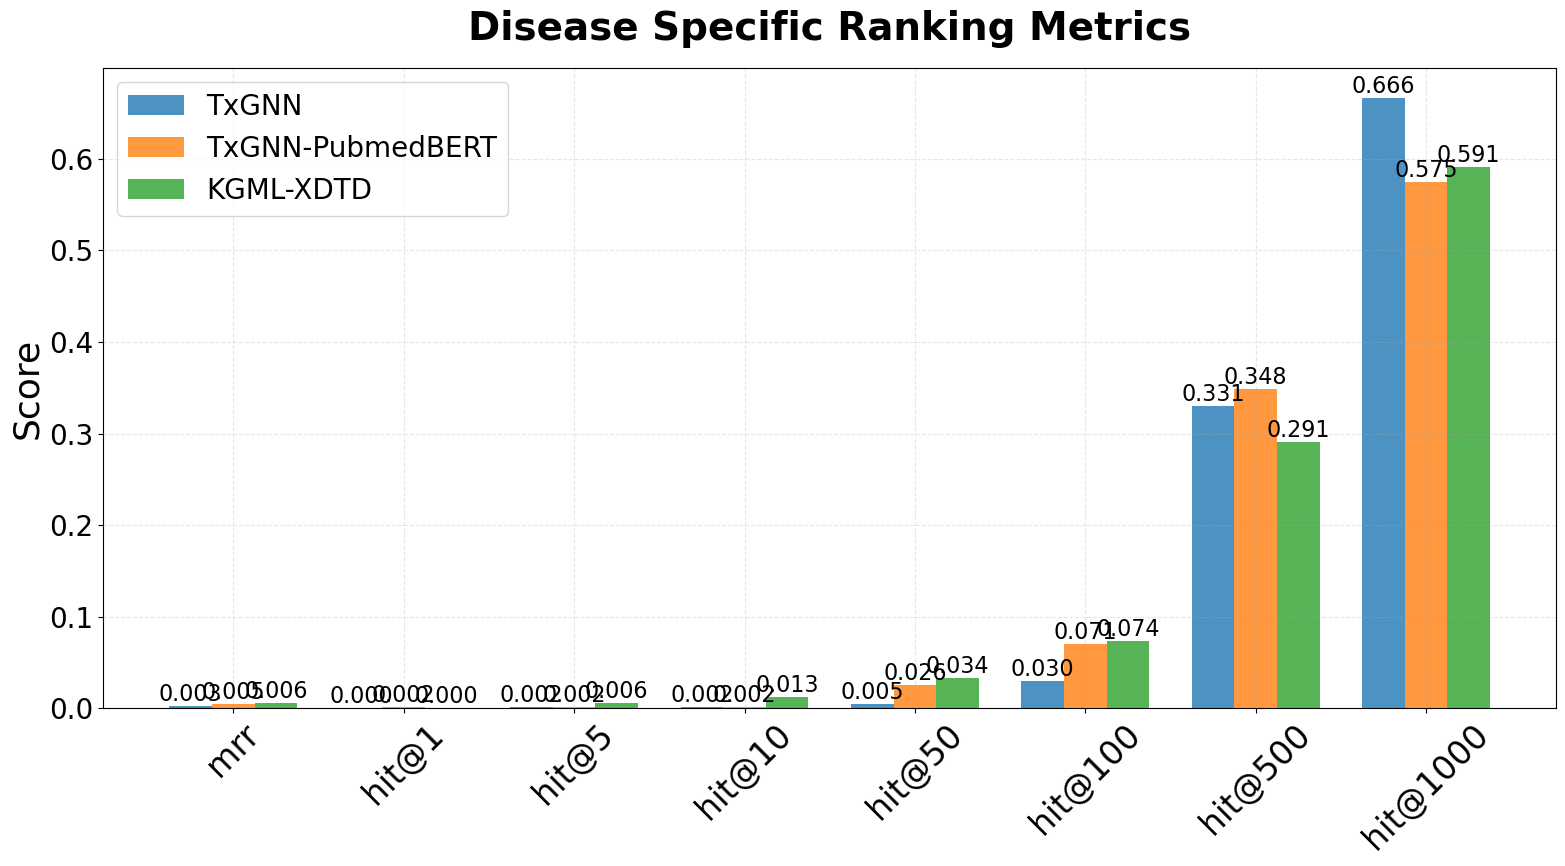

In [13]:
# 1. Disease Specific Ranking Plot
disease_metrics = ['mrr', 'hit@1', 'hit@5', 'hit@10', 'hit@50', 'hit@100', 'hit@500', 'hit@1000']
x = np.arange(len(disease_metrics))
width = 0.25  # Changed from 0.35 to accommodate three bars

fig, ax = plt.subplots(figsize=(16, 9))
bars1 = ax.bar(x - width, [result_dict[model1][m] for m in disease_metrics], width, 
       label=model1_legend, alpha=0.8)
bars2 = ax.bar(x, [result_dict[model2][m] for m in disease_metrics], width, 
       label=model2_legend, alpha=0.8)
bars3 = ax.bar(x + width, [result_dict[model3][m] for m in disease_metrics], width, 
       label=model3_legend, alpha=0.8)

def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height,
                f'{height:.3f}',
                ha='center', va='bottom', rotation=0, fontsize=16)

autolabel(bars1)
autolabel(bars2)
autolabel(bars3)
ax.set_ylabel('Score')
ax.set_title('Disease Specific Ranking Metrics', pad=20, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(disease_metrics, rotation=45)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
ax.legend()  # Uncommented the legend
plt.subplots_adjust(right=0.95)  # Adjusted right margin
plt.tight_layout()
plt.show()

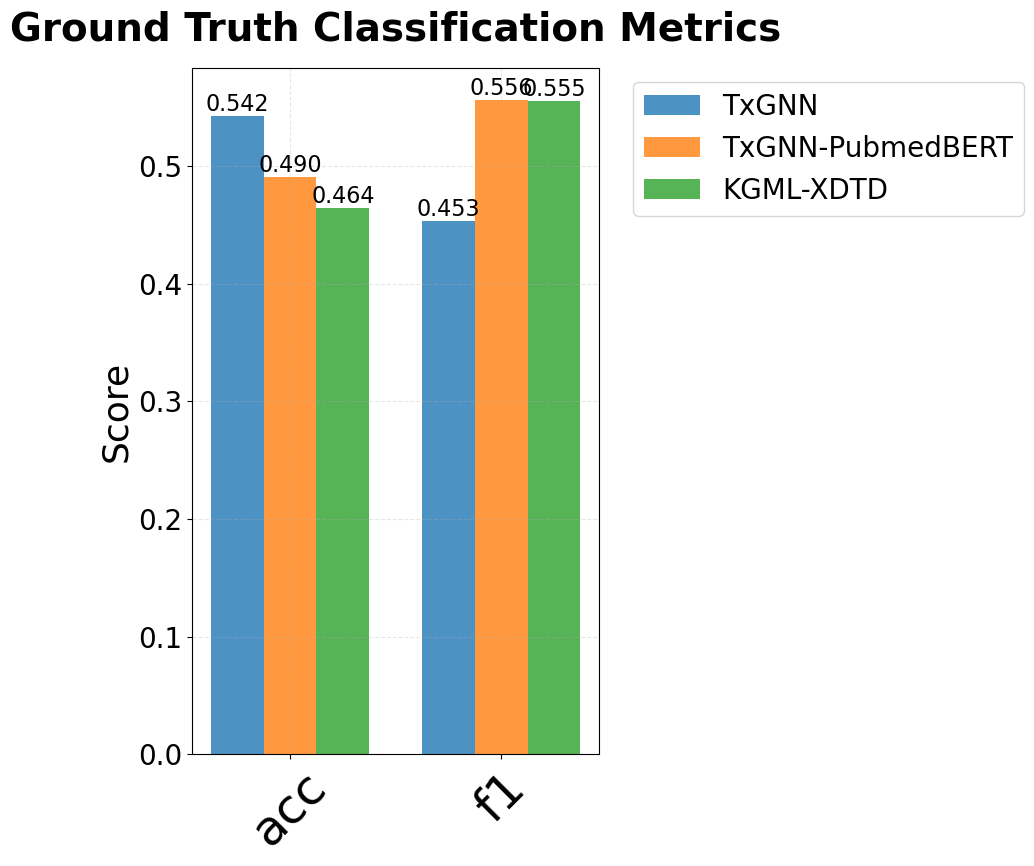

In [14]:
# 2. Ground Truth Classification Plot
metrics = ['acc', 'f1']  # Added f1 metric
x = np.arange(len(metrics))

fig, ax = plt.subplots(figsize=(10, 9))
bars1 = ax.bar(x - width, [result_dict[model1][m] for m in metrics], width, 
       label=model1_legend, alpha=0.8)
bars2 = ax.bar(x, [result_dict[model2][m] for m in metrics], width, 
       label=model2_legend, alpha=0.8)
bars3 = ax.bar(x + width, [result_dict[model3][m] for m in metrics], width, 
       label=model3_legend, alpha=0.8)

autolabel(bars1)
autolabel(bars2)
autolabel(bars3)

ax.set_ylabel('Score')
ax.set_title('Ground Truth Classification Metrics', pad=20, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, fontsize=35)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
plt.subplots_adjust(right=0.95)  # Adjusted right margin
plt.tight_layout()
plt.show()

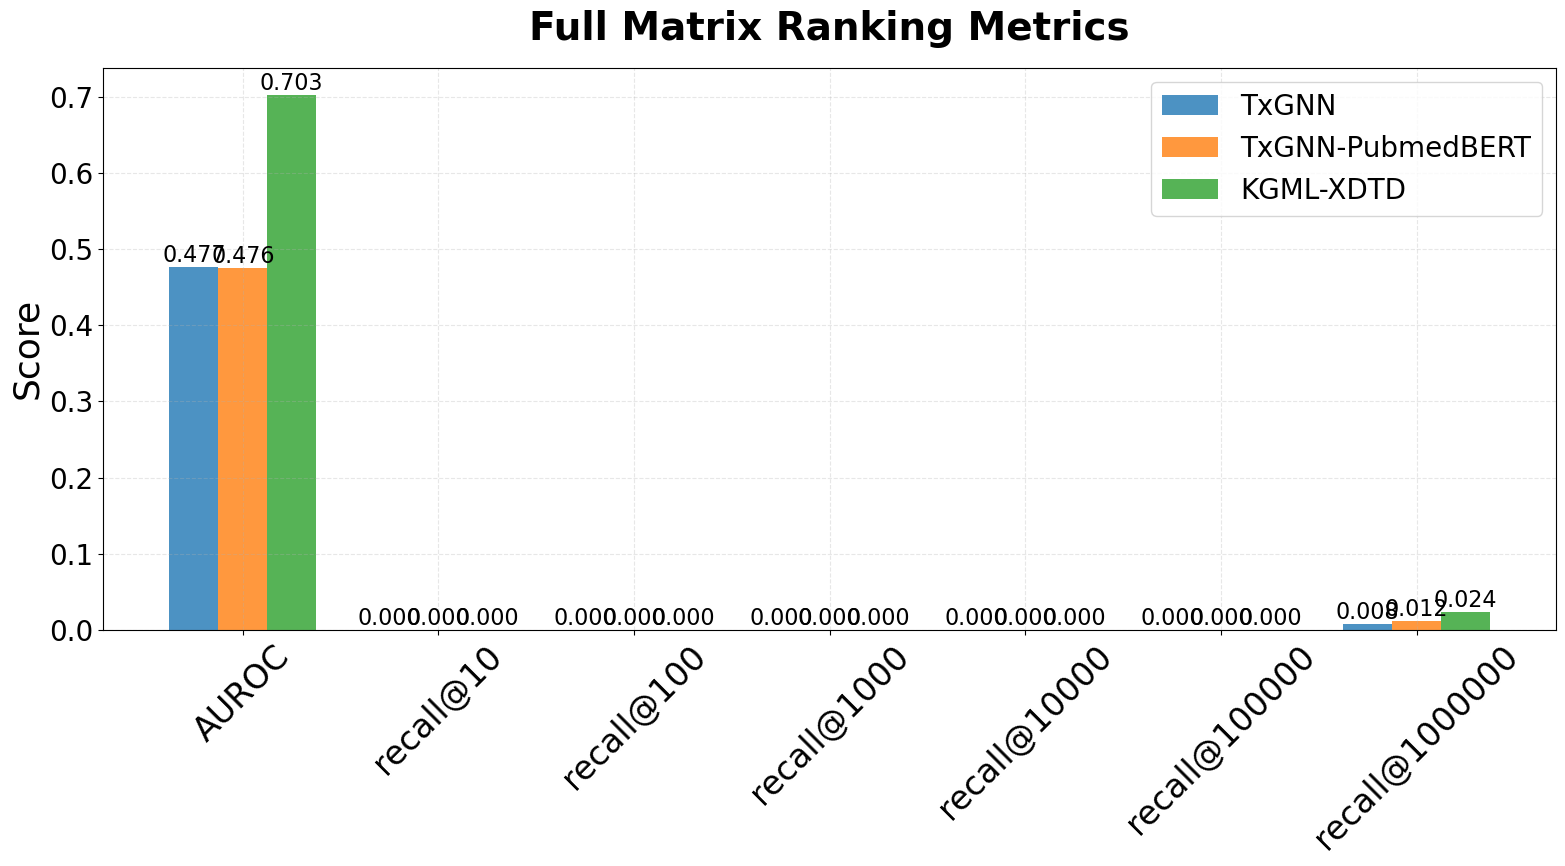

In [15]:
# 3. Full Matrix Ranking Plot
matrix_metrics = ['AUROC', 'recall@10', 'recall@100', 'recall@1000', 
                 'recall@10000', 'recall@100000', 'recall@1000000']
x = np.arange(len(matrix_metrics))

fig, ax = plt.subplots(figsize=(16, 9))
bars1 = ax.bar(x - width, [result_dict[model1][m] for m in matrix_metrics], width, 
       label=model1_legend, alpha=0.8)
bars2 = ax.bar(x, [result_dict[model2][m] for m in matrix_metrics], width, 
       label=model2_legend, alpha=0.8)
bars3 = ax.bar(x + width, [result_dict[model3][m] for m in matrix_metrics], width, 
       label=model3_legend, alpha=0.8)

autolabel(bars1)
autolabel(bars2)
autolabel(bars3)

ax.set_ylabel('Score')
ax.set_title('Full Matrix Ranking Metrics', pad=20, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(matrix_metrics, rotation=45)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend()  # Added legend back
plt.subplots_adjust(right=0.95)  # Adjusted right margin
plt.tight_layout()
plt.show()

From the comparison results of "Neurodegenerative Disease" evalution experiment, we found that TxGNN also demonstrates superior performance in disease-specific ranking metrics but is worse than KGML-xDTD in the full matrix ranking metrics.